In [1]:
%matplotlib inline

In [2]:
import adolc

In [3]:
from adapt_utils.case_studies.tohoku.options.okada_options import TohokuOkadaOptions
from adapt_utils.misc import taylor_test
from adapt_utils.norms import vecnorm

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [5]:
np.random.seed(0)  # make results reproducible

# Inverting the Okada model for slip and rake only

The experiments in this notebook are very much the same as those in the previous one.
The only difference is that strike and dip are fixed at $198^\circ$ and $10^\circ$, respectively.

### Initialisation

Set parameters and create a `TohokuOkadaOptions` object to hold them.
Apply the Okada model with default input parameters to give the field we want to invert for, stored in memory as `eta`.

In [6]:
kwargs = {
    'okada_grid_resolution': 51,
    'debug': False,
}
plotting_kwargs = {
    'cmap': 'coolwarm',
    'levels': 50,
}
fontsize = 18
tick_fontsize = 12
active_controls = ('slip', 'rake')

In [7]:
op = TohokuOkadaOptions(**kwargs)
op.active_controls = active_controls
op.create_topography()
N = op.N
X = op.fault.dtopo.X
Y = op.fault.dtopo.Y
eta = op.fault.dtopo.dZ.copy()
m_orig = op.get_input_vector()
np.save("notebook_5_m_orig", m_orig)

### Differentatiate the source model

Perturb the control parameters with some Normal random noise so that the source is different from that used to generate the gauge timeseries data.
This effectively means 'choose an initial guess'.

In [8]:
kwargs['control_parameters'] = op.control_parameters
for control in op.active_controls:
    size = np.shape(op.control_parameters[control])
    kwargs['control_parameters'][control] += np.random.normal(loc=0, scale=10, size=size)

When setting the free surface initial condition using the Okada model, we tell `pyadolc` to annotate its tape.
For this application we need to modify the way that the tape is annotated by default and therefore pass the `interpolate` flag as `True`:

In [9]:
tape_tag = 0
op = TohokuOkadaOptions(**kwargs)
op._data_to_interpolate = eta
op.active_controls = active_controls
op.create_topography(annotate=True, interpolate=True, tag=tape_tag)
op.get_seed_matrices()  # these can be reused over and over
print("QoI = {:.4e}".format(op.J.val))
assert np.isclose(op.J.val, 3.0457e-01, rtol=1.0e-04)  # from previous run

QoI = 3.0457e-01


Create some arrays to keep track of the optimisation routine

In [10]:
op.J_progress = []
op.dJdm_progress = []

Sum over all subfaults to get the total QoI.
By unrolling the tape, we can easily express the reduced functional as a function of the active controls.
Note that we raise a flag which prepares for a subsequent reverse mode propagation.

In [11]:
def reduced_functional(m):
    """Apply the Okada model by unrolling the tape and compute the QoI."""
    J = sum(adolc.zos_forward(tape_tag, m, keep=1))
    op.J_progress.append(J)
    return J

In [12]:
J = reduced_functional(op.input_vector)
assert np.isclose(J, op.J.val)

The reverse mode of AD computes

$$
    \mathbf m_b:=\frac{\mathrm dJ}{\mathrm d\mathbf m}^T\:J_b,
$$

where $J_b$ is a scalar *seed* and $\mathbf m_b$ is of the same dimension as the control parameter vector.
Therefore we can propagate through the reverse mode of AD to get the gradient by choosing a unit seed.

In [13]:
def gradient(m):
    """Compute the gradient of the QoI with respect to the input parameters."""
    dJdm = adolc.fos_reverse(tape_tag, 1.0)
    op.dJdm_progress.append(vecnorm(dJdm, order=np.Inf))
    return dJdm

In [14]:
g = gradient(op.input_vector)
assert len(g) == len(op.input_vector)
print("J = {:.4e}  ||dJdm|| = {:.4e}".format(op.J_progress[-1], op.dJdm_progress[-1]))
assert np.isclose(op.dJdm_progress[-1], 2.0739e-03, rtol=1.0e-04)  # from previous run

J = 3.0457e-01  ||dJdm|| = 2.0739e-03


In [15]:
eta_pert = op.fault.dtopo.dZ.copy()

Check that the function stored to tape evaluates as it should

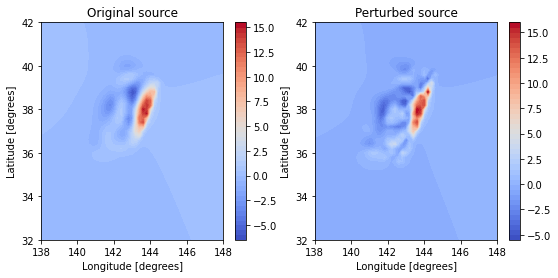

In [16]:
eta_pert = op.fault.dtopo.dZ.reshape(N, N)

fig, axes = plt.subplots()
cbar = fig.colorbar(axes.contourf(X, Y, eta, **plotting_kwargs), ax=axes);
cbar.ax.tick_params(labelsize=tick_fontsize);
axes.set_xlabel("Longitude [degrees]", fontsize=fontsize);
axes.set_ylabel("Latitude [degrees]", fontsize=fontsize);
for tick in axes.xaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
for tick in axes.yaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
plt.tight_layout()
plt.savefig("plots/notebook_5_original_source.pdf")
plt.close()

fig, axes = plt.subplots()
cbar = fig.colorbar(axes.contourf(X, Y, eta_pert, **plotting_kwargs), ax=axes);
cbar.ax.tick_params(labelsize=tick_fontsize);
axes.set_xlabel("Longitude [degrees]", fontsize=fontsize);
axes.set_ylabel("Latitude [degrees]", fontsize=fontsize);
for tick in axes.xaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
for tick in axes.yaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
plt.tight_layout()
plt.savefig("plots/notebook_5_perturbed_source.pdf")
plt.close()

fig, axes = plt.subplots(ncols=2, figsize=(9, 4))
fig.colorbar(axes[0].contourf(X, Y, eta, **plotting_kwargs), ax=axes[0]);
axes[0].set_title("Original source");
axes[0].set_xlabel("Longitude [degrees]");
axes[0].set_ylabel("Latitude [degrees]");
fig.colorbar(axes[1].contourf(X, Y, eta_pert, **plotting_kwargs), ax=axes[1]);
axes[1].set_title("Perturbed source");
axes[1].set_xlabel("Longitude [degrees]");
axes[1].set_ylabel("Latitude [degrees]");

### Taylor test

Before attempting gradient-based optimisation, we better check that our gradient function is consistent.

In [17]:
taylor_test(reduced_functional, gradient, op.input_vector, verbose=True)

========================TAYLOR TEST========================
h = 1.0000e+00
Taylor remainder = 2.1515e-03
h = 5.0000e-01
Taylor remainder = 5.3803e-04
h = 2.5000e-01
Taylor remainder = 1.3453e-04
====================TAYLOR TEST PASSED!====================


### Inversion

Now we are ready to do the gradient-based optimisation.
Here we use BFGS and require that the gradient norm is smaller than $10^{-8}$ for convergence.

In [20]:
# Reset progress arrays
op.J_progress = []
op.dJdm_progress = []

def opt_cb(m):
    """Print progress after every successful line search"""
    msg = "{:4d}: J = {:.4e}  ||dJdm|| = {:.4e}"
    counter = len(op.J_progress)
    if counter % 100 == 0:
        print(msg.format(counter, op.J_progress[-1], op.dJdm_progress[-1]))

opt_parameters = {
    'maxiter': 40000,
    'disp': True,
    'gtol': 1.0e-08,
    'callback': opt_cb,
    'retall': True,
    'fprime': gradient,
}

m_opt, out = scipy.optimize.fmin_bfgs(reduced_functional, op.input_vector, **opt_parameters)

 100: J = 2.7769e-03  ||dJdm|| = 8.3628e-05
 200: J = 7.8062e-04  ||dJdm|| = 2.1403e-05
 300: J = 3.2953e-04  ||dJdm|| = 8.9949e-06
 400: J = 1.7621e-04  ||dJdm|| = 7.9621e-06
 500: J = 9.5216e-05  ||dJdm|| = 3.7894e-06
 700: J = 4.1894e-05  ||dJdm|| = 2.8640e-06
 800: J = 3.0838e-05  ||dJdm|| = 1.6080e-06
 900: J = 2.3846e-05  ||dJdm|| = 2.0610e-06
1000: J = 1.8609e-05  ||dJdm|| = 1.9559e-06
1100: J = 1.4822e-05  ||dJdm|| = 5.7339e-07
1200: J = 1.1971e-05  ||dJdm|| = 6.7818e-07
1300: J = 1.0320e-05  ||dJdm|| = 5.5706e-07
1400: J = 8.8930e-06  ||dJdm|| = 5.2346e-07
1500: J = 7.5018e-06  ||dJdm|| = 5.2361e-07
1600: J = 6.7992e-06  ||dJdm|| = 1.9786e-07
1700: J = 5.8198e-06  ||dJdm|| = 6.0808e-07
1800: J = 5.2239e-06  ||dJdm|| = 2.8740e-07
1900: J = 4.7757e-06  ||dJdm|| = 1.4167e-07
2000: J = 4.1865e-06  ||dJdm|| = 3.5520e-07
2100: J = 3.5043e-06  ||dJdm|| = 4.9788e-07
2200: J = 3.1151e-06  ||dJdm|| = 2.1110e-07
2300: J = 2.7169e-06  ||dJdm|| = 2.2493e-07
2400: J = 2.4900e-06  ||dJdm|| =

In [21]:
np.save("notebook_5_m_opt", m_opt)
np.save("notebook_5_J_progress", op.J_progress)
np.save("notebook_5_dJdm_progress", op.dJdm_progress)

Let's take a look at the progress of the reduced functional and gradient

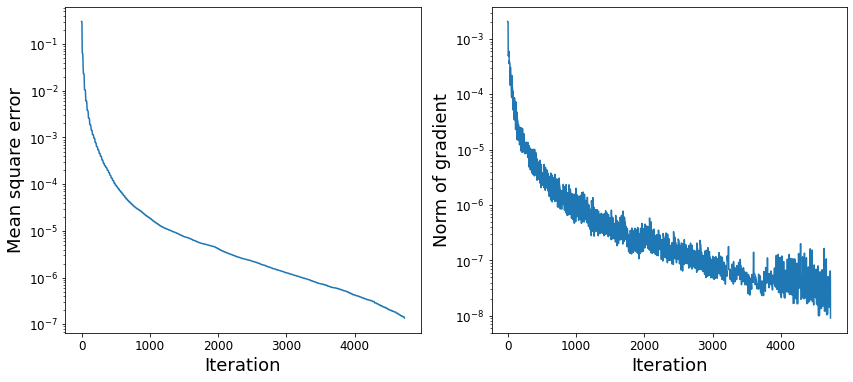

In [19]:
op.J_progress = np.load("notebook_5_J_progress.npy")
op.dJdm_progress = np.load("notebook_5_dJdm_progress.npy")

fig, axes = plt.subplots()
axes.semilogy(op.J_progress);
axes.set_xlabel("Iteration", fontsize=fontsize);
axes.set_ylabel("Mean square error", fontsize=fontsize);
for tick in axes.xaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
for tick in axes.yaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
plt.tight_layout()
plt.savefig("plots/notebook_5_J_progress.pdf")
plt.close()

fig, axes = plt.subplots()
axes.semilogy(op.dJdm_progress);
axes.set_xlabel("Iteration", fontsize=fontsize);
axes.set_ylabel(r"$\ell_\infty$-norm of gradient", fontsize=fontsize);
for tick in axes.xaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
for tick in axes.yaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
plt.tight_layout()
plt.savefig("plots/notebook_5_dJdm_progress.pdf")
plt.close()

fig, axes = plt.subplots(ncols=2, figsize=(14, 6))
ax = axes[0]
ax.semilogy(op.J_progress);
ax.set_xlabel("Iteration", fontsize=fontsize);
ax.set_ylabel("Mean square error", fontsize=fontsize);
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
ax = axes[1]
ax.semilogy(op.dJdm_progress);
ax.set_xlabel("Iteration", fontsize=fontsize);
ax.set_ylabel("Norm of gradient", fontsize=fontsize);
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);

Compare the optimised parameters, `m_opt`, against the original ones, `m_orig`.

In [20]:
m_opt = np.load("notebook_5_m_opt.npy")
m_orig = np.load("notebook_5_m_orig.npy")
diff = m_opt - m_orig
print("Mean square error of controls = {:.4e}".format(np.linalg.norm(diff)**2/len(m_opt)))

Mean square error of controls = 2.6317e+01


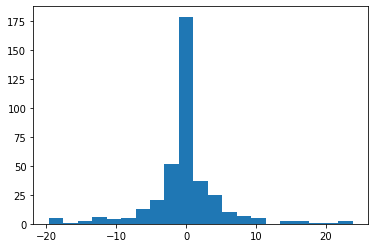

In [21]:
plt.hist(diff, bins=21);

In [22]:
diff = diff.reshape(op.nx*op.ny, len(op.active_controls))
for j, row in enumerate(diff):
    print("{:3d}: {:8.4f}, {:8.4f}".format(j, *row))

  0:   0.0042, -17.6233
  1:   0.0127,  -0.3642
  2:  -0.0862,   2.5470
  3:   0.1441,   0.6666
  4:   0.1984,  -0.7519
  5:   0.0445,  -1.3829
  6:  -0.0128,  -1.4164
  7:  -0.0425,  -0.5678
  8:  -0.1328,  -0.3565
  9:  -0.0957,   0.9414
 10:   0.0842,   0.1467
 11:  -0.0176,  -0.9272
 12:  -0.3296,   2.8170
 13:   0.1138,  10.7877
 14:   0.4942,   2.0199
 15:  -0.0429,   2.6049
 16:   0.0635,   0.6268
 17:  -0.0197,  -1.7477
 18:   0.0033,   2.5249
 19:   0.0227,  -1.5209
 20:  -0.0705,  -1.6858
 21:  -0.2031,   2.9710
 22:  -0.1217,   3.2045
 23:   0.2691,   4.7145
 24:   2.8163,  -4.0525
 25:  -1.4924,  -1.9521
 26:   0.3398,  -1.7923
 27:  -2.2588,   0.4757
 28:   0.7465,   1.6796
 29:   1.1338,   0.2658
 30:  -0.8618,  -0.0385
 31:  -0.8120,  -1.2394
 32:   0.4900,  -2.0073
 33:   0.4814,  -0.6589
 34:   0.0835,  -6.3157
 35:  -0.1158,  -0.3084
 36:  -0.0003,   2.8322
 37:   0.0031,   0.2222
 38:   0.0578,  -5.0315
 39:  -0.1080,  -1.8516
 40:  -0.3751,  -2.6592
 41:  -1.4510,  

In [23]:
msg = "Maximum pointwise difference: {:.4f} degree difference in {:s} on subfault {:d}"
loc = np.unravel_index(np.argmax(np.abs(diff), axis=None), diff.shape)
print(msg.format(diff[loc], op.active_controls[loc[1]], loc[0]))

Maximum pointwise difference: 23.8703 degree difference in rake on subfault 89


In [24]:
op = TohokuOkadaInversionOptions(**kwargs)
op.active_controls = active_controls
m_opt = np.load("notebook_5_m_opt.npy")
m_opt = m_opt.reshape(op.nx*op.ny, len(op.active_controls))
for i, control in enumerate(op.active_controls):
    op.control_parameters[control] = m_opt[:, i]
    op.create_topography()

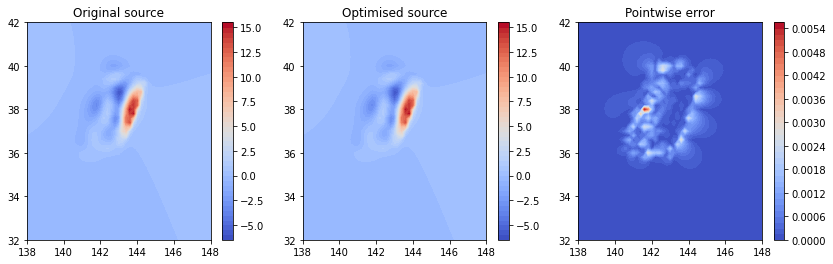

In [25]:
eta_opt = op.fault.dtopo.dZ.reshape(N, N)
eta_err = np.abs(eta - eta_opt)

fig, axes = plt.subplots()
cbar = fig.colorbar(axes.contourf(X, Y, eta_opt, **plotting_kwargs), ax=axes);
cbar.ax.tick_params(labelsize=tick_fontsize);
axes.set_xlabel("Longitude [degrees]", fontsize=fontsize);
axes.set_ylabel("Latitude [degrees]", fontsize=fontsize);
for tick in axes.xaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
for tick in axes.yaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
plt.tight_layout()
plt.savefig("plots/notebook_5_optimised_source.pdf")
plt.close()

fig, axes = plt.subplots()
cbar = fig.colorbar(axes.contourf(X, Y, eta_err, **plotting_kwargs), ax=axes);
cbar.ax.tick_params(labelsize=tick_fontsize);
axes.set_xlabel("Longitude [degrees]", fontsize=fontsize);
axes.set_ylabel("Latitude [degrees]", fontsize=fontsize);
for tick in axes.xaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
for tick in axes.yaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
plt.tight_layout()
plt.savefig("plots/notebook_5_pointwise_error.pdf")
plt.close()

fig, axes = plt.subplots(ncols=3, figsize=(14, 4))
fig.colorbar(axes[0].contourf(X, Y, eta, **plotting_kwargs), ax=axes[0]);
axes[0].set_title("Original source");
fig.colorbar(axes[1].contourf(X, Y, eta_opt, **plotting_kwargs), ax=axes[1]);
axes[1].set_title("Optimised source");
fig.colorbar(axes[2].contourf(X, Y, eta_err, **plotting_kwargs), ax=axes[2]);
axes[2].set_title("Pointwise error");